In [1]:
from time import sleep
import Pyro5.api 
import matplotlib.pyplot as plt
from TimeTagger import *
import numpy as np
from scipy.optimize import curve_fit

# CW second-order autocorrelation function

In [38]:
# CdSe/ZnS core-shell quantum dots
file_1 = 'C:/Users/HP/Downloads/TimeTags_CW_2025-02-19_130331.ttbin' #QD_55 (CW) (Antibunching 0.189) (22.68 ns)  

# C_60 molecules
file_2 = 'C:/Users/HP/Downloads/TimeTags_CW_Ful_2025-02-06_152655.ttbin' #QD_29 (CW) (Antibunching 0.291) (3.80 ns)

In [39]:
fr_1 = FileReader(file_1)
fr_2 = FileReader(file_2)
print("All channels available: {}".format(fr_1.getChannelList()))
print("All channels available: {}".format(fr_2.getChannelList()))

print("Has data? ->", fr_1.hasData())
print("Has data? ->", fr_2.hasData())
# Returns: True if more data is available for reading, False if all data has been read from all the files specified in the class constructor.

All channels available: (1, 2)
All channels available: (1, 2)
Has data? -> True
Has data? -> True


In [40]:
virtual_tagger = createTimeTaggerVirtual()
virtual_tagger.getConfiguration()


{'configure version': 1,
 'current time': '2025-06-04 10:33:13 +0200',
 'hardware configuration': None,
 'measurements': [],
 'replay speed': -1.0,
 'software clock': None,
 'software version': '2.17.4',
 'virtual inputs': []}

In [41]:
bwcorr = 500 # ps
nbins = 400

In [42]:
config_1 = fr_1.getConfiguration()

# measure photon antibunching
corr_ch1 = config_1['registered channels'][0] # first photon channel for antibunching measurements
corr_ch2 = config_1['registered channels'][1] # second photon channel for antibunching measurements

corr = Correlation(virtual_tagger, corr_ch1, corr_ch2, bwcorr, nbins)
cr = Countrate(virtual_tagger, [corr_ch1, corr_ch2])

virtual_tagger.setReplaySpeed(-1.0) # Speed of -1.0 will replay the data as fast as possible
virtual_tagger.replay(file_1, begin = 0, duration = -1) # collect data until the end 
virtual_tagger.waitForCompletion()

# normalized correlation -> Photon Antibunching
xcorr_1 = corr.getIndex()
ycorr_1 = corr.getData()

In [43]:
config_2 = fr_2.getConfiguration()

# measure photon antibunching
corr_ch1 = config_2['registered channels'][0] # first photon channel for antibunching measurements
corr_ch2 = config_2['registered channels'][1] # second photon channel for antibunching measurements


corr = Correlation(virtual_tagger, corr_ch1, corr_ch2, bwcorr, nbins)
cr = Countrate(virtual_tagger, [corr_ch1, corr_ch2])

virtual_tagger.setReplaySpeed(-1.0) # Speed of -1.0 will replay the data as fast as possible
virtual_tagger.replay(file_2, begin = 0, duration = -1) # collect data until the end 
virtual_tagger.waitForCompletion()

# normalized correlation -> Photon Antibunching
xcorr_2 = corr.getIndex()
ycorr_2 = corr.getData()

In [44]:
# Define the fitting function: a * (1 - b * exp(abs(tau - t0) / tau0)
def fitting_function(tau, t_0, tau_0, a, b):
    return a * (1 - b * np.exp(-np.abs(tau - t_0) / tau_0))

# Function to normalize counts and fit the data
def fit_params(tau, counts, expected_a):
    
    # Perform the curve fitting
    popt, pcov = curve_fit(fitting_function, tau, counts, p0=[2, 10, expected_a, 1])
    
    return popt, pcov
    
def plot_fit_noblinking_norm(tau, counts, t_0, tau_0, a, b, width, height, font_size):
    # Generar la curva ajustada
    tau_fine = np.linspace(min(tau), max(tau), 10000)
    fitted_curve = fitting_function(tau_fine, t_0, tau_0, a, b)
    # Cálculo del error como raíz cuadrada de counts
    errors = np.sqrt(counts)
    # Crear la figura
    plt.figure(figsize=(width, height))
    # Banda de error: área sombreada entre (counts - error) y (counts + error)
    plt.fill_between(tau, (counts - errors)/a, (counts + errors)/a, color="#FFC5C5", alpha=1.0)
    # Línea ajustada
    plt.plot(tau_fine, fitted_curve/a, color="#FF0000", linewidth = 1)
    # Etiquetas de los ejes con tamaño de fuente modificado
    plt.xlabel('Time differences (ns)', fontsize=font_size)
    plt.ylabel('Counts', fontsize=font_size)
    # Cambiar el tamaño de los números en los ejes
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    # Activar la cuadrícula
    plt.grid(True)
    # Mostrar el gráfico
    plt.show()

In [45]:
popt, pcov = fit_params(xcorr_1/1000, ycorr_1, 100)
t_0_1, tau_0_1, a_1, b_1 = popt

popt, pcov = fit_params(xcorr_2/1000, ycorr_2, 100)
t_0_2, tau_0_2, a_2, b_2 = popt

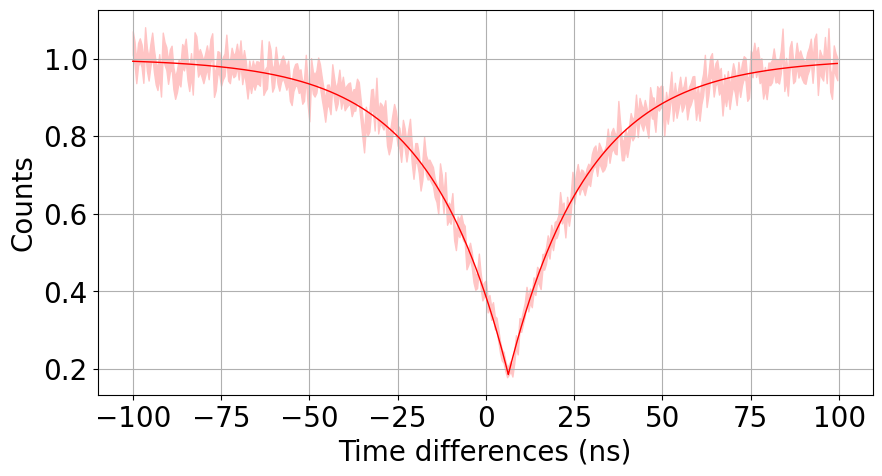

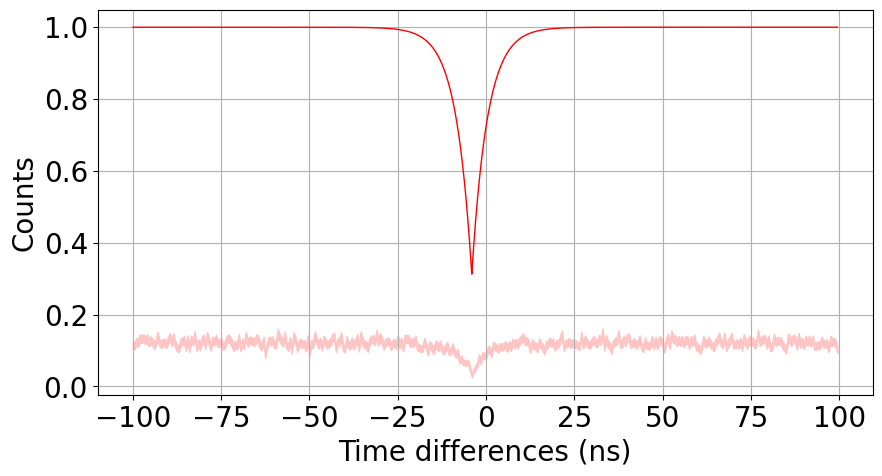

In [46]:
plot_fit_noblinking_norm(xcorr_1/1000, ycorr_1, t_0_1, tau_0_1, a_1, b_1, width=10, height=5, font_size=20)
plot_fit_noblinking_norm(xcorr_2/1000, ycorr_2, t_0_2, tau_0_2, a_1, b_2, width=10, height=5, font_size=20)

In [47]:
def plot_1_vs_2(tau_1, counts_1, tau_2, counts_2, width, height, font_size):
    
    popt, pcov = fit_params(tau_1, counts_1, 100)
    t_0_1, tau_0_1, a_1, b_1 = popt
    popt, pcov = fit_params(tau_2, counts_2, 100)
    t_0_2, tau_0_2, a_2, b_2 = popt
    
    # Generar la curva ajustada
    tau_fine_1 = np.linspace(min(tau_1), max(tau_1), 10000)
    tau_fine_2 = np.linspace(min(tau_2), max(tau_2), 10000)
    fitted_curve_1 = fitting_function(tau_fine_1, t_0_1, tau_0_1, a_1, b_1)
    fitted_curve_2 = fitting_function(tau_fine_2, t_0_2, tau_0_2, a_2, b_2)
    # Cálculo del error como raíz cuadrada de counts
    errors_1 = np.sqrt(counts_1)
    errors_2 = np.sqrt(counts_2)
    # Crear la figura
    plt.figure(figsize=(width, height))
    # Banda de error: área sombreada entre (counts - error) y (counts + error)
    plt.fill_between(tau_1, (counts_1 - errors_1)/a_1, (counts_1 + errors_1)/a_1, color="#FF0000", alpha=0.2)
    plt.fill_between(tau_2, (counts_2 - errors_2)/a_2, (counts_2 + errors_2)/a_2, color="#0004FF", alpha=0.2)
    # Línea ajustada
    plt.plot(tau_fine_1, fitted_curve_1/a_1, color="#FF0000", linewidth = 1)
    plt.plot(tau_fine_2, fitted_curve_2/a_2, color="#0004FF", linewidth = 1)
    # Etiquetas de los ejes con tamaño de fuente modificado
    plt.xlabel('Time differences (ns)', fontsize=font_size)
    plt.ylabel('Normalized counts', fontsize=font_size)
    # Cambiar el tamaño de los números en los ejes
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    # Activar la cuadrícula
    plt.grid(True)
    # Mostrar el gráfico
    plt.show()

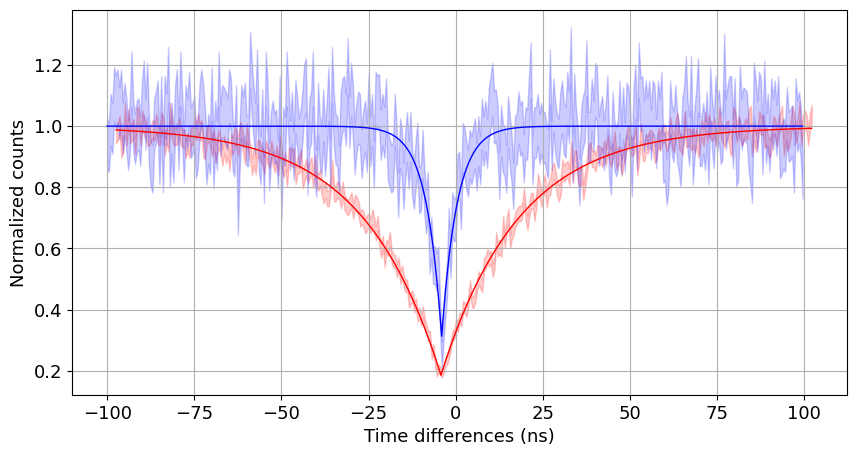

In [48]:
xcorr_1_invert =  xcorr_1[::-1] + 2600
plot_1_vs_2(xcorr_1_invert/1000, ycorr_1, xcorr_2/1000, ycorr_2, width=10, height=5, font_size=13)

# PW second-order autocorrelation function

In [5]:
# CdSe/ZnS core-shell quantum dots
file_1 = 'C:/Users/HP/Downloads/TimeTagsPulsed_10MHz_2024-11-29_161622.ttbin' #QD_35 (PW) (Antibunching 0.221)

# C_60 molecules
file_2 = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-06_153714.ttbin' #QD_29 (PW) (Antibunching 0.308)

In [6]:
fr_1 = FileReader(file_1)
fr_2 = FileReader(file_2)
print("All channels available: {}".format(fr_1.getChannelList()))
print("All channels available: {}".format(fr_2.getChannelList()))

print("Has data? ->", fr_1.hasData())
print("Has data? ->", fr_2.hasData())
# Returns: True if more data is available for reading, False if all data has been read from all the files specified in the class constructor.

All channels available: (1, 2)
All channels available: (1, 2)
Has data? -> True
Has data? -> True


In [29]:
virtual_tagger = createTimeTaggerVirtual()
virtual_tagger.getConfiguration()

bwcorr = 600 # ps
nbins = 900

In [30]:
config_1 = fr_1.getConfiguration()

# measure photon antibunching
corr_ch1 = config_1['registered channels'][0] # first photon channel for antibunching measurements
corr_ch2 = config_1['registered channels'][1] # second photon channel for antibunching measurements

corr = Correlation(virtual_tagger, corr_ch1, corr_ch2, bwcorr, nbins)
cr = Countrate(virtual_tagger, [corr_ch1, corr_ch2])

virtual_tagger.setReplaySpeed(-1.0) # Speed of -1.0 will replay the data as fast as possible
virtual_tagger.replay(file_1, begin = 0, duration = -1) # collect data until the end 
virtual_tagger.waitForCompletion()

# normalized correlation -> Photon Antibunching
xcorr_1 = corr.getIndex()
ycorr_1 = corr.getData()

In [31]:
config_2 = fr_2.getConfiguration()

# measure photon antibunching
corr_ch1 = config_2['registered channels'][0] # first photon channel for antibunching measurements
corr_ch2 = config_2['registered channels'][1] # second photon channel for antibunching measurements


corr = Correlation(virtual_tagger, corr_ch1, corr_ch2, bwcorr, nbins)
cr = Countrate(virtual_tagger, [corr_ch1, corr_ch2])

virtual_tagger.setReplaySpeed(-1.0) # Speed of -1.0 will replay the data as fast as possible
virtual_tagger.replay(file_2, begin = 0, duration = -1) # collect data until the end 
virtual_tagger.waitForCompletion()

# normalized correlation -> Photon Antibunching
xcorr_2 = corr.getIndex()
ycorr_2 = corr.getData()

In [32]:
rep_rate = 100 #ns (Repetition rate of the pulsed laser)

In [33]:
# Define the fitting function: 
def fitting_function(tau, a,
                     b1, t1, tau1,
                     b2, t2, tau2,
                     b3, t3, tau3,
                     b4, t4, tau4,
                     b5, t5, tau5):
    peaks = [(b1, t1, tau1), (b2, t2, tau2), (b3, t3, tau3),
             (b4, t4, tau4), (b5, t5, tau5)]
    return a + sum(b * np.exp(-np.abs(tau - t_0) / tau_0) for b, t_0, tau_0 in peaks)


def fit_noblinking(tau, counts):
    global rep_rate

    p0 = [
        1,               # a
        1, -2*rep_rate, 5,  # b1, t1, tau1 (pico más a la izquierda)
        1, -rep_rate, 5,    # b2, t2, tau2 (pico izquierdo)
        5, 0, 10,           # b3, t3, tau3 (pico central)
        1, rep_rate, 5,     # b4, t4, tau4 (pico derecho)
        1, 2*rep_rate, 5    # b5, t5, tau5 (pico más a la derecha)
    ]

    popt, pcov = curve_fit(fitting_function, tau, counts, p0=p0)
    return popt, pcov

# Function to plot the normalized data and the fitted curve
def plot_fit_noblinking(tau, counts, params, width, height, font_size):
    
    norm_factor = (4/(params[1]+params[4]+params[10]+params[13]))
    
    # Generar valores finos para la curva ajustada
    tau_fine = np.linspace(min(tau), max(tau), 100000)  # 100k puntos ya es suficiente
    fitted_curve = fitting_function(tau_fine, *params)
    
    # Calcular errores (raíz cuadrada de counts)
    errors = np.sqrt(counts)
    
    # Crear la figura
    plt.figure(figsize=(width, height))
    
    # Banda de error con valores no negativos
    lower = np.maximum(counts - errors, 0)
    upper = counts + errors
    plt.fill_between(tau, lower * norm_factor, upper * norm_factor, color="#FDA4A4", alpha=0.3)
    
    # Curva ajustada
    plt.plot(tau_fine, fitted_curve * norm_factor, 'r-', linewidth=1)
    
    # Etiquetas y formato
    plt.xlabel('Time differences (ns)', fontsize=font_size)
    plt.ylabel('Counts', fontsize=font_size)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    
    # Cuadrícula y leyenda
    plt.grid(True)
    plt.legend(fontsize=font_size)
    
    # Ajuste del layout y mostrar
    plt.tight_layout()
    plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_27320\1980075698.py:10: RuntimeWarning: overflow encountered in exp
  return a + sum(b * np.exp(-np.abs(tau - t_0) / tau_0) for b, t_0, tau_0 in peaks)
C:\Users\HP\AppData\Local\Temp\ipykernel_27320\1980075698.py:25: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitting_function, tau, counts, p0=p0)
C:\Users\HP\AppData\Local\Temp\ipykernel_27320\1980075698.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=font_size)


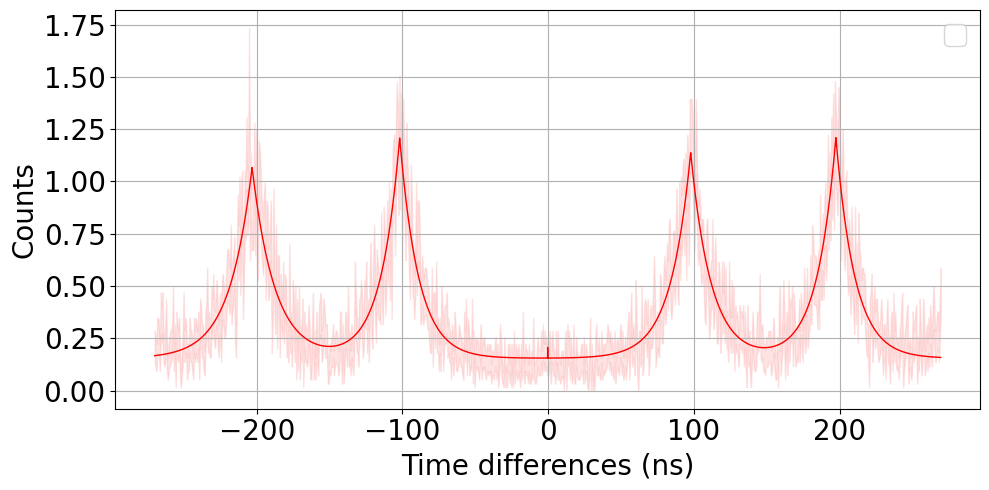

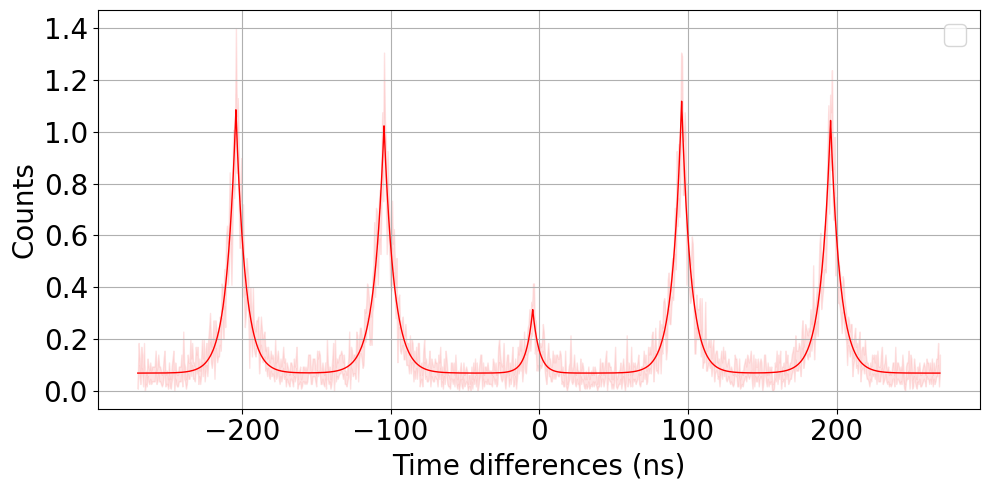

In [34]:
params_1, perr_1 = fit_noblinking(xcorr_1/1000, ycorr_1)
plot_fit_noblinking(xcorr_1/1000, ycorr_1, params_1, width=10, height=5, font_size=20)

params_2, perr_2 = fit_noblinking(xcorr_2/1000, ycorr_2)
plot_fit_noblinking(xcorr_2/1000, ycorr_2, params_2, width=10, height=5, font_size=20)

In [35]:
# CQDs
perr_1 = np.sqrt(np.diag(perr_1))

# Ahora imprime los resultados:
print(f"a: {params_1[0]:.3f} ± {perr_1[0]:.3f} counts\n")

for i in range(5):
    idx = 1 + i * 3
    try:
        print(f"b{i+1}: {params_1[idx]:.3f} ± {perr_1[idx]:.3f} counts")
        print(f"t{i+1}: {params_1[idx+1]:.3f} ± {perr_1[idx+1]:.3f} ns")
        print(f"tau{i+1}: {params_1[idx+2]:.3f} ± {perr_1[idx+2]:.3f} ns\n")
    except IndexError:
        print(f"[!] Error: Index {idx} out of bounds — check number of fitted parameters.")

a: 5.841 ± inf counts

b1: 34.518 ± inf counts
t1: -203.161 ± inf ns
tau1: 15.659 ± inf ns

b2: 39.817 ± inf counts
t2: -101.884 ± inf ns
tau2: 13.054 ± inf ns

b3: 2.410 ± inf counts
t3: -0.322 ± inf ns
tau3: 0.011 ± inf ns

b4: 37.192 ± inf counts
t4: 97.830 ± inf ns
tau4: 13.943 ± inf ns

b5: 39.923 ± inf counts
t5: 197.464 ± inf ns
tau5: 13.084 ± inf ns



In [36]:
# C_60
perr_2 = np.sqrt(np.diag(perr_2))

# Ahora imprime los resultados:
print(f"a: {params_2[0]:.3f} ± {perr_2[0]:.3f} counts\n")

for i in range(5):
    idx = 1 + i * 3
    try:
        print(f"b{i+1}: {params_2[idx]:.3f} ± {perr_2[idx]:.3f} counts")
        print(f"t{i+1}: {params_2[idx+1]:.3f} ± {perr_2[idx+1]:.3f} ns")
        print(f"tau{i+1}: {params_2[idx+2]:.3f} ± {perr_2[idx+2]:.3f} ns\n")
    except IndexError:
        print(f"[!] Error: Index {idx} out of bounds — check number of fitted parameters.")

a: 5.261 ± 0.165 counts

b1: 79.164 ± 1.619 counts
t1: -204.000 ± 0.091 ns
tau1: 6.296 ± 0.189 ns

b2: 74.343 ± 1.559 counts
t2: -104.400 ± 0.103 ns
tau2: 6.729 ± 0.208 ns

b3: 19.094 ± 1.969 counts
t3: -4.410 ± 0.311 ns
tau3: 4.287 ± 0.641 ns

b4: 81.717 ± 1.634 counts
t4: 95.738 ± 0.087 ns
tau4: 6.184 ± 0.182 ns

b5: 75.941 ± 1.594 counts
t5: 195.890 ± 0.096 ns
tau5: 6.491 ± 0.201 ns



In [37]:
def plot_1_vs_2_PW(tau_1, counts_1, tau_2, counts_2, width, height, font_size):
    
    params_1, _ = fit_noblinking(tau_1, counts_1)
    params_2, _ = fit_noblinking(tau_2, counts_2)
    
    norm_factor_1 = (4/(params_1[1]+params_1[4]+params_1[10]+params_1[13]))
    norm_factor_2 = (4/(params_2[1]+params_2[4]+params_2[10]+params_2[13]))
    
    # Generar valores finos para la curva ajustada
    tau_fine_1 = np.linspace(min(tau_1), max(tau_1), 100000)  
    tau_fine_2 = np.linspace(min(tau_2), max(tau_2), 100000)  
    fitted_curve_1 = fitting_function(tau_fine_1, *params_1)
    fitted_curve_2 = fitting_function(tau_fine_2, *params_2)
    
    # Calcular errores (raíz cuadrada de counts)
    errors_1 = np.sqrt(counts_1)
    errors_2 = np.sqrt(counts_2)
    
    # Crear la figura
    plt.figure(figsize=(width, height))
    
    # Banda de error con valores no negativos
    lower_1 = np.maximum(counts_1 - errors_1, 0)
    lower_2 = np.maximum(counts_2 - errors_2, 0)
    upper_1 = counts_1 + errors_1
    upper_2 = counts_2 + errors_2
    plt.fill_between(tau_1, lower_1 * norm_factor_1, upper_1 * norm_factor_1, color="#FF0000", alpha=0.2)
    plt.fill_between(tau_2, lower_2 * norm_factor_2, upper_2 * norm_factor_2, color="#0004FF", alpha=0.2)
    
    # Curva ajustada
    plt.plot(tau_fine_1, fitted_curve_1 * norm_factor_1, color="#FF0000", linewidth=1)
    plt.plot(tau_fine_2, fitted_curve_2 * norm_factor_2, color="#0004FF", linewidth=1)
    
    # Etiquetas y formato
    plt.xlabel('Time differences (ns)', fontsize=font_size)
    plt.ylabel('Normalized counts', fontsize=font_size)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    
    # Cuadrícula y leyenda
    plt.grid(True)
    
    # Ajuste del layout y mostrar
    plt.tight_layout()
    plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_27320\1980075698.py:10: RuntimeWarning: overflow encountered in exp
  return a + sum(b * np.exp(-np.abs(tau - t_0) / tau_0) for b, t_0, tau_0 in peaks)


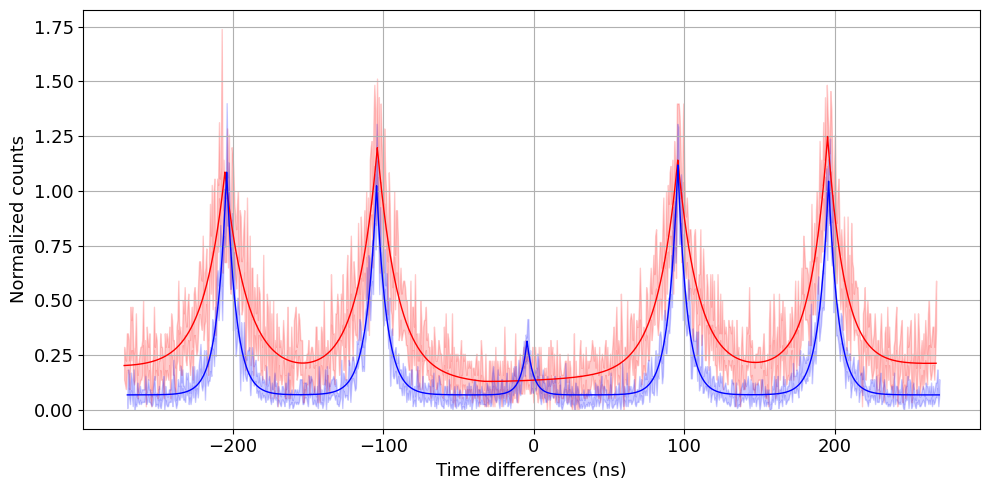

In [38]:
xcorr_1_invert =  xcorr_1 - 2100
plot_1_vs_2_PW(xcorr_1_invert/1000, ycorr_1, xcorr_2/1000, ycorr_2, width=10, height=5, font_size=13)

# Lifetime

In [2]:
import pandas as pd

In [3]:
# CdSe/ZnS core-shell quantum dots  
# file_name_1 = 'C:/Users/HP/Downloads/Histogram_2024-12-03_131131.txt' #QD_43
# file_name_1 = 'C:/Users/HP/Downloads/Histogram_2024-12-03_123603.txt' #QD_42
file_name_1 = 'C:/Users/HP/Downloads/Histogram_2025-01-22_143122.txt' #QD_46
file_name_1 = 'C:/Users/HP/Downloads/Histogram_2025-01-23_162634.txt' #QD_48
file_name_1 = 'C:/Users/HP/Downloads/Histogram_2025-01-23_175527.txt' #QD_49
file_name_1 = 'C:/Users/HP/Downloads/Histogram_2025-02-19_144221.txt' #QD_55

# C_60 molecules
file_name_2 = 'C:/Users/HP/Downloads/Histogram_2025-02-06_154014.txt' #QD_29

In [4]:
data_1 = pd.read_csv(file_name_1, sep="\t")  # Read the file with tab as the delimiter
# Extract the columns
x_1 = data_1["Time (ps)"] / 1000 # Time in ns
y_1 = data_1["Counts per bin"]

data_2 = pd.read_csv(file_name_2, sep="\t")  # Read the file with tab as the delimiter
# Extract the columns
x_2 = data_2["Time (ps)"] / 1000 # Time in ns
y_2 = data_2["Counts per bin"]

In [5]:
def plot_lineal(x, y, fit_ini, width, height, font_size):

    plt.figure(figsize=(width, height))  # Define el tamaño de la figura
    plt.plot(x - min(x), y, marker='o', color='black', markersize=0, linestyle='-', linewidth=0.5, label='Data')
    plt.plot(x[fit_ini::] - min(x), y[fit_ini::], marker='o', color='red', markersize=1, linestyle='-', linewidth=1, label='Fitting points')
    
    # Cambiar el tamaño de los números en los ejes
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    
    # plt.title('Histogram Plot (Linear Scale)')
    plt.xlabel('Time (ns)', fontsize=font_size)
    plt.ylabel('Counts per bin', fontsize=font_size)
    plt.grid(True)
    plt.legend(fontsize=font_size)
    
    plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

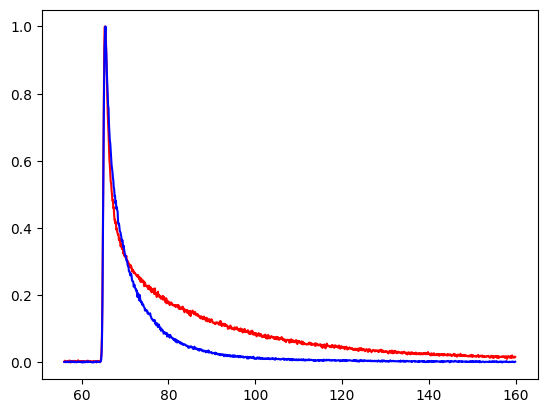

In [27]:
width = 6
height = 4
font_size = 15

i_ini = 560 # Inital index of the plot
i_end = 1600 # Final index of the plot
fit_ini = 96 # Initial index for the fit

cut = 52
y_1_cut = y_1[i_ini+cut:i_end+cut]
y_2_cut = y_2[i_ini:i_end]

plt.plot(x_1[i_ini:i_end], (y_1_cut-min(y_1_cut))/max(y_1_cut-min(y_1_cut)), color="#FF0000")
plt.plot(x_2[i_ini:i_end], (y_2_cut-min(y_2_cut))/max(y_2_cut-min(y_2_cut)), color="#0004FF")
plt.show

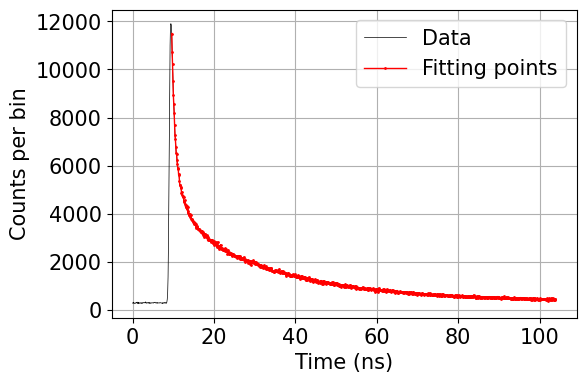

1040
1040


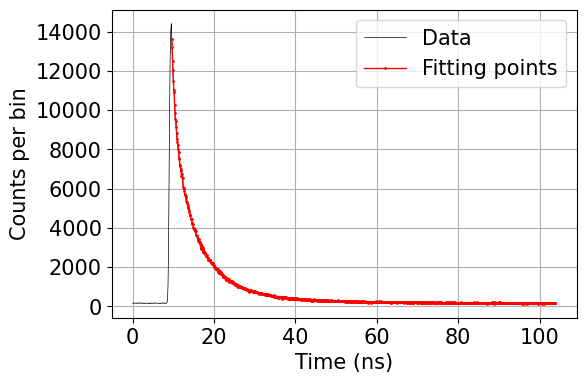

In [28]:
plot_lineal(x_1[i_ini:i_end], y_1[i_ini+cut:i_end+cut], fit_ini, width, height, font_size)
print(len(y_2[i_ini:i_end])) 
print(len(x_2[i_ini:i_end]))
plot_lineal(x_2[i_ini:i_end], y_2[i_ini:i_end], fit_ini, width, height, font_size)


In [29]:
def exp_func_2(x, A, B_1, x_0_1, tau_1, B_2, x_0_2, tau_2):
    return A + B_1 * np.exp(-(x - x_0_1) / tau_1) + B_2 * np.exp(-(x - x_0_2) / tau_2) 

def fit_exponential_2(x, y):
    
    params, pcov = curve_fit(exp_func_2, x, y, p0=[np.min(y), np.max(y)-np.min(y), np.min(x), 6.0, np.max(y)-np.min(y), np.min(x), 0.4])
    return params, pcov

def plot_fit_logarithmic_2(x, y, fit_ini, params, width, height, font_size):
    
    x_fit = np.linspace(min(x[fit_ini::]), max(x[fit_ini::]), 1000)
    y_fit = exp_func_2(x_fit, *params)
    
    errors = np.sqrt(y)
    
    plt.figure(figsize=(width, height))
    
    plt.fill_between(x - min(x), y - errors, y + errors, color="#FF0000", alpha=0.2)
    plt.plot(x_fit - min(x), y_fit, marker='o', color='red', markersize=0, linestyle='-', linewidth=1, label='Fitted graph')
    
    # Cambiar el tamaño de los números en los ejes
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    
    # plt.title('Exponential Fit')
    plt.xlabel('Time (ns)', fontsize=font_size)
    plt.ylabel('Counts per bin', fontsize=font_size)
    plt.yscale('log')  # Set Y-axis to logarithmic scale
    plt.grid(True)
    #plt.legend(fontsize=font_size)
    
    plt.show()

c:\Users\HP\miniconda3\envs\TTenv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


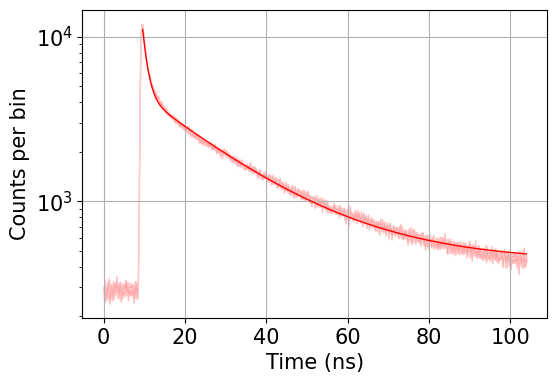

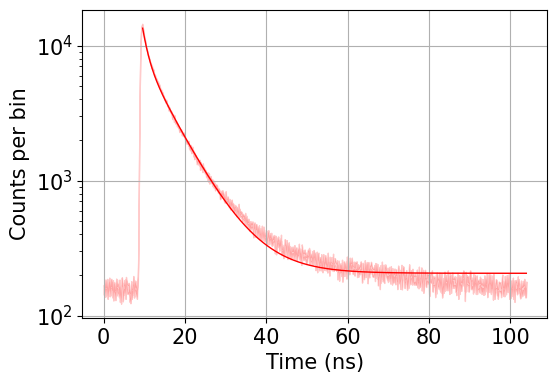

In [30]:
params_1, pcov_1 = fit_exponential_2(x_1[(i_ini + fit_ini):i_end], y_1[(i_ini + fit_ini + cut):i_end+cut])
params_2, pcov_2 = fit_exponential_2(x_2[(i_ini + fit_ini):i_end], y_2[(i_ini + fit_ini):i_end])

plot_fit_logarithmic_2(x_1[i_ini:i_end],  y_1[i_ini+cut:i_end+cut], fit_ini, params_1, width, height, font_size)
plot_fit_logarithmic_2(x_2[i_ini:i_end], y_2[i_ini:i_end], fit_ini, params_2, width, height, font_size)

In [31]:
def plot_1_vs_2_Lifetime_2(x_1, y_1, x_2, y_2, i_ini, fit_ini, i_end, width, height, font_size):
    
    params_1, _ = fit_exponential_2(x_1[fit_ini:i_end], y_1[fit_ini:i_end])
    params_2, _ = fit_exponential_2(x_2[fit_ini:i_end], y_2[fit_ini:i_end])
    
    x_fit_1 = np.linspace(min(x_1[fit_ini::]), max(x_1[fit_ini::]), 1000)
    y_fit_1 = exp_func_2(x_fit_1, *params_1)
    x_fit_2 = np.linspace(min(x_2[fit_ini::]), max(x_2[fit_ini::]), 1000)
    y_fit_2 = exp_func_2(x_fit_2, *params_2)
    
    errors_1 = np.sqrt(y_1)
    errors_2 = np.sqrt(y_2)
    
    plt.figure(figsize=(width, height))
    
    # lower_1 = (y_1 - errors_1 - min(y_1 - errors_1))/max(y_1 - errors_1) + 1
    # upper_1 = (y_1 + errors_1 - min(y_1 + errors_1))/max(y_1 + errors_1) + 1
    # lower_2 = (y_2 - errors_2 - min(y_2 - errors_2))/max(y_2 - errors_2) + 1
    # upper_2 = (y_2 + errors_2 - min(y_2 + errors_2))/max(y_2 + errors_2) + 1
    
    lower_1 = (y_1 - errors_1)
    upper_1 = (y_1 + errors_1)
    lower_2 = (y_2 - errors_2)
    upper_2 = (y_2 + errors_2)
    
    plt.fill_between(x_1 - min(x_1), lower_1, upper_1, color="#FF0000", alpha=0.2)
    plt.fill_between(x_2 - min(x_2), lower_2, upper_2, color="#0004FF", alpha=0.2)
    plt.plot(x_fit_1 - min(x_1), y_fit_1, marker='o', color="#FF0000", markersize=0, linestyle='-', linewidth=1)
    plt.plot(x_fit_2 - min(x_2), y_fit_2, marker='o', color="#0004FF", markersize=0, linestyle='-', linewidth=1)
    
    # Cambiar el tamaño de los números en los ejes
    plt.xticks(fontsize=font_size)
    plt.yscale('log')  # Set Y-axis to logarithmic scale
    plt.yticks([])
    
    # plt.title('Exponential Fit')
    plt.xlabel('Time (ns)', fontsize=font_size)
    plt.ylabel('Counts (a.u.)', fontsize=font_size)
    plt.minorticks_on()
    plt.grid(True, which='both', axis='both', linestyle='-', linewidth=0.5)  # Grid cuadriculado

    plt.show()

c:\Users\HP\miniconda3\envs\TTenv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


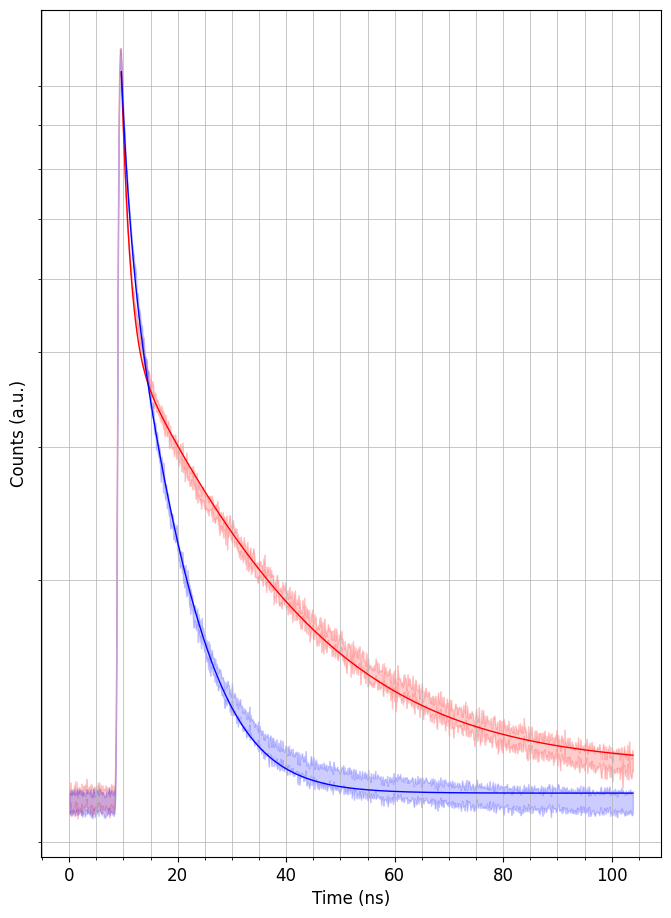

In [32]:
# Valores de renormalización
new_min = 1000
new_max = 10000
# Renormalización de y_1[i_ini+cut:i_end+cut]
y_1_slice = y_1[i_ini + cut : i_end + cut]
y_1_min, y_1_max = np.min(y_1_slice), np.max(y_1_slice)
y_1_comp = new_min + ((y_1_slice - y_1_min) / (y_1_max - y_1_min)) * (new_max - new_min)
# Renormalización de y_2[i_ini:i_end]
y_2_slice = y_2[i_ini : i_end]
y_2_min, y_2_max = np.min(y_2_slice), np.max(y_2_slice)
y_2_comp = new_min + ((y_2_slice - y_2_min) / (y_2_max - y_2_min)) * (new_max - new_min)

plot_1_vs_2_Lifetime_2(x_1[i_ini:i_end], y_1_comp, x_2[i_ini:i_end], y_2_comp, i_ini, fit_ini, i_end, width=8, height=11, font_size = 12)
# plot_1_vs_2_Lifetime(x_1[i_ini:i_end], y_1[i_ini+cut:i_end+cut], x_2[i_ini:i_end], y_2[i_ini:i_end], i_ini, fit_ini, i_end, width=6, height=5, font_size = 13)

In [33]:
def exp_func_3(x, A, B_1, x_0_1, tau_1, B_2, x_0_2, tau_2, B_3, x_0_3, tau_3):
    return A + B_1 * np.exp(-(x - x_0_1) / tau_1) + B_2 * np.exp(-(x - x_0_2) / tau_2) + B_3 * np.exp(-(x - x_0_3) / tau_3)

def fit_exponential_3(x, y):
    
    initial_guess = [np.min(y), np.max(y)-np.min(y), np.min(x), 6.0, np.max(y)-np.min(y), np.min(x), 0.4, np.max(y)-np.min(y), np.min(x), 0.04]
    params, pcov = curve_fit(exp_func_3, x, y, p0=initial_guess)
    return params, pcov

In [34]:
def plot_1_vs_2_Lifetime_3(x_1, y_1, x_2, y_2, i_ini, fit_ini, i_end, width, height, font_size):
    
    params_1, _ = fit_exponential_3(x_1[fit_ini:i_end], y_1[fit_ini:i_end])
    params_2, _ = fit_exponential_3(x_2[fit_ini:i_end], y_2[fit_ini:i_end])
    
    x_fit_1 = np.linspace(min(x_1[fit_ini::]), max(x_1[fit_ini::]), 1000)
    y_fit_1 = exp_func_3(x_fit_1, *params_1)
    x_fit_2 = np.linspace(min(x_2[fit_ini::]), max(x_2[fit_ini::]), 1000)
    y_fit_2 = exp_func_3(x_fit_2, *params_2)
    
    errors_1 = np.sqrt(y_1)
    errors_2 = np.sqrt(y_2)
    
    plt.figure(figsize=(width, height))
    
    # lower_1 = (y_1 - errors_1 - min(y_1 - errors_1))/max(y_1 - errors_1) + 1
    # upper_1 = (y_1 + errors_1 - min(y_1 + errors_1))/max(y_1 + errors_1) + 1
    # lower_2 = (y_2 - errors_2 - min(y_2 - errors_2))/max(y_2 - errors_2) + 1
    # upper_2 = (y_2 + errors_2 - min(y_2 + errors_2))/max(y_2 + errors_2) + 1
    
    lower_1 = (y_1 - errors_1)
    upper_1 = (y_1 + errors_1)
    lower_2 = (y_2 - errors_2)
    upper_2 = (y_2 + errors_2)
    
    plt.fill_between(x_1 - min(x_1), lower_1, upper_1, color="#FF0000", alpha=0.2)
    plt.fill_between(x_2 - min(x_2), lower_2, upper_2, color="#0004FF", alpha=0.2)
    plt.plot(x_fit_1 - min(x_1), y_fit_1, marker='o', color="#FF0000", markersize=0, linestyle='-', linewidth=1)
    plt.plot(x_fit_2 - min(x_2), y_fit_2, marker='o', color="#0004FF", markersize=0, linestyle='-', linewidth=1)
    
    # Cambiar el tamaño de los números en los ejes
    plt.xticks(fontsize=font_size)
    plt.yscale('log')  # Set Y-axis to logarithmic scale
    plt.yticks([])
    
    # plt.title('Exponential Fit')
    plt.xlabel('Time (ns)', fontsize=font_size)
    plt.ylabel('Counts (a.u.)', fontsize=font_size)
    plt.minorticks_on()
    plt.grid(True, which='both', axis='both', linestyle='-', linewidth=0.5)  # Grid cuadriculado

    plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_25816\3519665633.py:7: OptimizeWarning: Covariance of the parameters could not be estimated
  params, pcov = curve_fit(exp_func_3, x, y, p0=initial_guess)
c:\Users\HP\miniconda3\envs\TTenv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


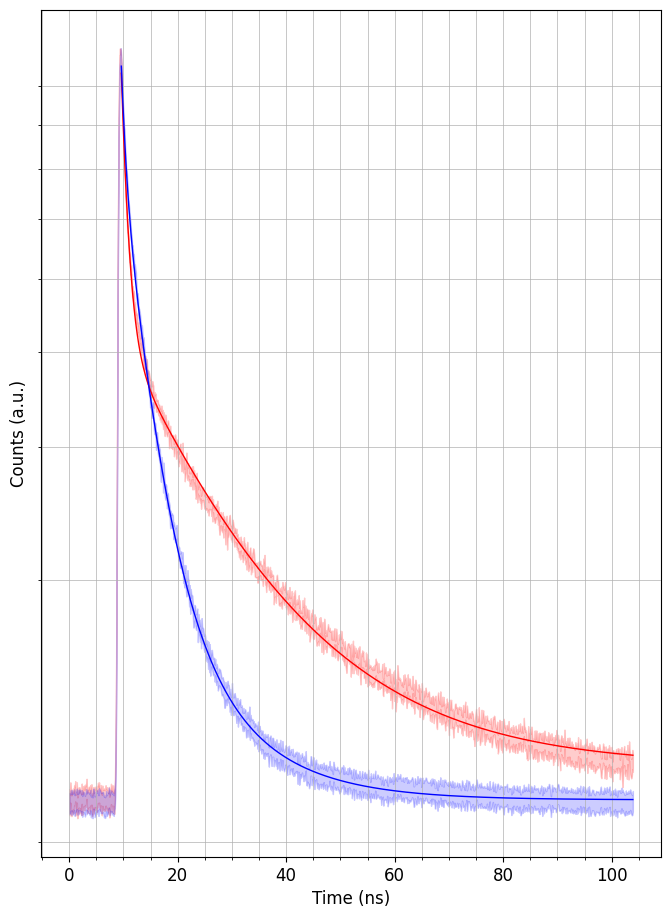

In [35]:
params_1, pcov_1 = fit_exponential_3(x_1[(i_ini + fit_ini):i_end], y_1[(i_ini + fit_ini + cut):i_end+cut])
params_2, pcov_2 = fit_exponential_3(x_2[(i_ini + fit_ini):i_end], y_2[(i_ini + fit_ini):i_end])

# Valores de renormalización
new_min = 1000
new_max = 10000
# Renormalización de y_1[i_ini+cut:i_end+cut]
y_1_slice = y_1[i_ini + cut : i_end + cut]
y_1_min, y_1_max = np.min(y_1_slice), np.max(y_1_slice)
y_1_comp = new_min + ((y_1_slice - y_1_min) / (y_1_max - y_1_min)) * (new_max - new_min)
# Renormalización de y_2[i_ini:i_end]
y_2_slice = y_2[i_ini : i_end]
y_2_min, y_2_max = np.min(y_2_slice), np.max(y_2_slice)
y_2_comp = new_min + ((y_2_slice - y_2_min) / (y_2_max - y_2_min)) * (new_max - new_min)

plot_1_vs_2_Lifetime_3(x_1[i_ini:i_end], y_1_comp, x_2[i_ini:i_end], y_2_comp, i_ini, fit_ini, i_end, width=8, height=11, font_size = 12)

In [36]:
# Calculate the standard deviations of the parameters 
perr_1 = np.sqrt(np.diag(pcov_1))

print(f"A: {params_1[0]:.3f} ± {perr_1[0]:.3f} counts\n")
print(f"B_1: {params_1[1]:.3f} ± {perr_1[1]:.3f} counts")
print(f"t_0_1: {params_1[2]:.3f} ± {perr_1[2]:.3f} ns")
print(f"tau_1: {params_1[3]:.3f} ± {perr_1[3]:.3f} ns\n")
print(f"B_2: {params_1[4]:.3f} ± {perr_1[4]:.3f} counts")
print(f"t_0_2: {params_1[5]:.3f} ± {perr_1[5]:.3f} ns")
print(f"tau_2: {params_1[6]:.3f} ± {perr_1[6]:.3f} ns\n")
print(f"B_3: {params_1[7]:.3f} ± {perr_1[7]:.3f} counts")
print(f"t_0_3: {params_1[8]:.3f} ± {perr_1[8]:.3f} ns")
print(f"tau_3: {params_1[9]:.3f} ± {perr_1[9]:.3f} ns\n")

tau_averaged_1 = (params_1[1]*params_1[3] + params_1[4]*params_1[6] + params_1[7]*params_1[9])/(params_1[1] + params_1[4] + params_1[7])
err_tau_averaged_1 = np.sqrt(params_1[1]**2*perr_1[3]**2 + params_1[4]**2*perr_1[6]**2 + params_1[7]**2*perr_1[9]**2)/(params_1[1] + params_1[4] + params_1[7])

print(f"tau_averaged (CQD): {tau_averaged_1:.3f} ± {err_tau_averaged_1:.3f} ns")

A: 362.160 ± 4.497 counts

B_1: 3835.582 ± 514078525.738 counts
t_0_1: 63.380 ± 3357168.627 ns
tau_1: 25.059 ± 0.198 ns

B_2: 2499.541 ± 325145098.802 counts
t_0_2: 65.839 ± 400594.336 ns
tau_2: 3.079 ± 0.101 ns

B_3: 5279.941 ± 763920650.448 counts
t_0_3: 65.559 ± 99729.153 ns
tau_3: 0.689 ± 0.015 ns

tau_averaged (CQD): 9.251 ± 0.069 ns


In [37]:
# Calculate the standard deviations of the parameters 
perr_2 = np.sqrt(np.diag(pcov_2))

print(f"A: {params_2[0]:.3f} ± {perr_2[0]:.3f} counts\n")
print(f"B_1: {params_2[1]:.3f} ± {perr_2[1]:.3f} counts")
print(f"t_0_1: {params_2[2]:.3f} ± {perr_2[2]:.3f} ns")
print(f"tau_1: {params_2[3]:.3f} ± {perr_2[3]:.3f} ns\n")
print(f"B_2: {params_2[4]:.3f} ± {perr_2[4]:.3f} counts")
print(f"t_0_2: {params_2[5]:.3f} ± {perr_2[5]:.3f} ns")
print(f"tau_2: {params_2[6]:.3f} ± {perr_2[6]:.3f} ns\n")
print(f"B_3: {params_2[7]:.3f} ± {perr_2[7]:.3f} counts")
print(f"t_0_3: {params_2[8]:.3f} ± {perr_2[8]:.3f} ns")
print(f"tau_3: {params_2[9]:.3f} ± {perr_2[9]:.3f} ns\n")

tau_averaged_2 = (params_2[1]*params_2[3] + params_2[4]*params_2[6] + params_2[7]*params_2[9])/(params_2[1] + params_2[4] + params_2[7])
err_tau_averaged_2 = np.sqrt(params_2[1]**2*perr_2[3]**2 + params_2[4]**2*perr_2[6]**2 + params_2[7]**2*perr_2[9]**2)/(params_2[1] + params_2[4] + params_2[7])

print(f"tau_averaged (C_60): {tau_averaged_2:.3f} ± {err_tau_averaged_2:.3f} ns")

A: 172.094 ± 2.186 counts

B_1: 2556.068 ± 256564997.483 counts
t_0_1: 62.817 ± 1322070.541 ns
tau_1: 13.171 ± 0.459 ns

B_2: 7354.227 ± 836956721.875 counts
t_0_2: 65.653 ± 565532.982 ns
tau_2: 4.969 ± 0.098 ns

B_3: 4269.355 ± 538241023.896 counts
t_0_3: 65.552 ± 105431.627 ns
tau_3: 0.836 ± 0.017 ns

tau_averaged (C_60): 5.203 ± 0.097 ns
